In [10]:
### IMPORTS ###
%load_ext autoreload
%autoreload 2
import sys, os

# Project-specific imports
sys.path.append(os.path.abspath("src"))
from pathlib import Path
from src.train import Trainer
from utils import save_model, set_global_seed
from utils_visualization import plot_metrics, load_history, visualize_slices
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
EXPERIMENT = "exp22_nnunet"
BASE_DIR = Path("results") / EXPERIMENT
CHECKPOINT_DIR = BASE_DIR / "checkpoints"
MODEL_DIR = BASE_DIR / "models"
LOG_DIR = BASE_DIR / "logs"
PRED_DIR         = BASE_DIR / "predictions"

In [19]:
### SETTINGS ###
# Training hyperparameters (must match what you used in main.py)
DATA_DIR         = "/datasets/tdt4265/mic/open/HNTS-MRG"
BATCH_SIZE       = 3
LEARNING_RATE    = 1e-3
EARLY_STOP_COUNT = 30
EPOCHS           = 200
IN_CHANNELS      = 1
OUT_CHANNELS     = 3

# Reproducibility
set_global_seed(0)

In [ ]:
trainer = Trainer(
    data_dir         = DATA_DIR,
    batch_size       = BATCH_SIZE,
    learning_rate    = LEARNING_RATE,
    early_stop_count = EARLY_STOP_COUNT,
    epochs           = EPOCHS,
    in_channels      = IN_CHANNELS,
    out_channels     = OUT_CHANNELS,
    checkpoint_dir   = CHECKPOINT_DIR,
)
trainer.train()

# (Optional) Save final model
token_model = trainer.model
save_model(token_model, MODEL_DIR)

Loading history from results/exp22_nnunet/logs/history_067.json


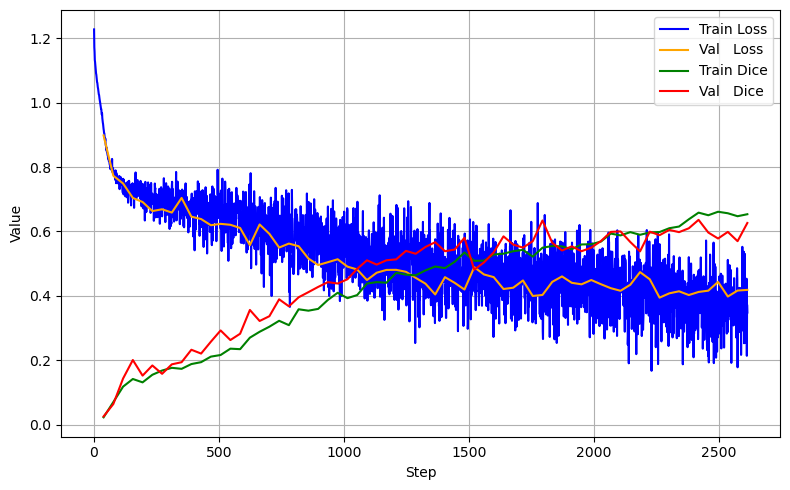

In [20]:
### PLOTTING ###
from pathlib import Path

# Automatically pick the latest history file:
history_files = sorted(
    Path(LOG_DIR).glob("history_*.json"),
    key=lambda p: int(p.stem.split('_')[-1])  # sort by epoch number in filename
)
latest_history = history_files[-1]
print(f"Loading history from {latest_history}")
history = load_history(str(latest_history))

# Plot curves
plot_metrics(
    history,
    metrics=[
        ("train",      "loss", "Train Loss",       "blue"),
        ("validation", "loss", "Val   Loss",       "orange"),
        ("train",      "dice", "Train Dice",      "green"),
        ("validation", "dice", "Val   Dice",      "red"),
    ]
)


In [21]:
# Extract summary into DataFrame
records = []
for step_str in history["validation"]["dice"]:
    step = int(step_str)
    records.append({
        "step": step,
        "train_loss": history["train"]["loss"].get(step_str),
        "val_loss":   history["validation"]["loss"].get(step_str),
        "train_dice": history["train"]["dice"].get(step_str),
        "val_dice":   history["validation"]["dice"].get(step_str),
        "train_dice_class1": history["train"].get("dice_class1", {}).get(step_str),
        "val_dice_class1":   history["validation"].get("dice_class1", {}).get(step_str),
        "train_dice_class2": history["train"].get("dice_class2", {}).get(step_str),
        "val_dice_class2":   history["validation"].get("dice_class2", {}).get(step_str),
    })
df = pd.DataFrame(records).sort_values("step")

# Final metrics
final = df.iloc[-1]
print(
    f"At globalstep {final.step}:\n"
    f"Train Loss = {final.train_loss:.3f}, Val Loss = {final.val_loss:.3f}\n"
    f"Train Avg Dice = {final.train_dice:.3f}, Val Avg Dice = {final.val_dice:.3f}\n"
    f"Train Class1 Dice = {final.train_dice_class1:.3f}, Val Class1 Dice = {final.val_dice_class1:.3f}\n"
    f"Train Class2 Dice = {final.train_dice_class2:.3f}, Val Class2 Dice = {final.val_dice_class2:.3f}\n"
)



At globalstep 2613.0:
Train Loss = 0.348, Val Loss = 0.418
Train Avg Dice = 0.653, Val Avg Dice = 0.626
Train Class1 Dice = 0.581, Val Class1 Dice = 0.614
Train Class2 Dice = 0.726, Val Class2 Dice = 0.639



In [22]:
# Find the step with the best validation Dice score
best_idx = df["val_dice"].idxmax()
best = df.loc[best_idx]

print(
    f"Best model was at globalstep {best.step}:\n"
    f"Train Loss = {best.train_loss:.3f}, Val Loss = {best.val_loss:.3f}\n"
    f"Train Avg Dice = {best.train_dice:.3f}, Val Avg Dice = {best.val_dice:.3f}\n"
    f"Train Class1 Dice = {best.train_dice_class1:.3f}, Val Class1 Dice = {best.val_dice_class1:.3f}\n"
    f"Train Class2 Dice = {best.train_dice_class2:.3f}, Val Class2 Dice = {best.val_dice_class2:.3f}\n"
)


Best model was at globalstep 2418.0:
Train Loss = 0.478, Val Loss = 0.412
Train Avg Dice = 0.658, Val Avg Dice = 0.636
Train Class1 Dice = 0.596, Val Class1 Dice = 0.658
Train Class2 Dice = 0.721, Val Class2 Dice = 0.614



Label class distribution: (1757047, 3773, 8652)
Prediction class distribution: (1743935, 2986, 22551)


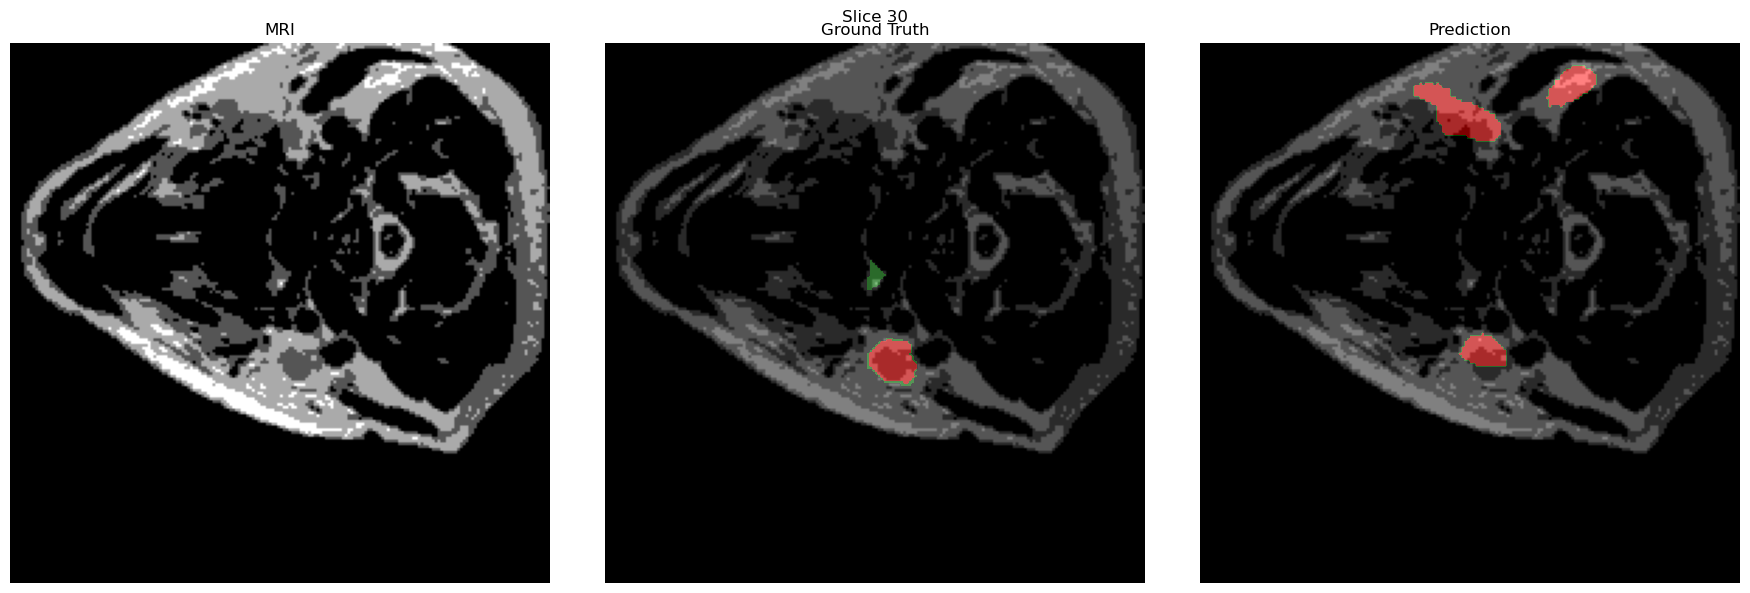

In [17]:
### VISUALIZATION ###
image_path = "results/exp22_nnunet/predictions/image_2.nii.gz"
label_path = "results/exp22_nnunet/predictions/label_2.nii.gz"
prediction_path = "results/exp22_nnunet/predictions/prediction_2.nii.gz"

# Visualize a specific slice (e.g., slice 50)
visualize_slices(image_path, label_path, prediction_path, slice_idx=30)
